In [ ]:
!ogr2ogr -sql "SELECT * FROM multipolygons WHERE admin_level='8'" -f "ESRI Shapefile" la_cities los_angeles.osm.pbf
!ogr2ogr -sql "SELECT * FROM points WHERE population IS NOT NULL and name IS NOT NULL" -f "GeoJSON" la_cities.geojson los_angeles.osm.pbf
!gdal_merge.py -o socal.tif -of png N3?W1??.hgt

In [90]:
from collections import OrderedDict
import random
import json

import numpy as np
import numpy.ma as ma

import gdal

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.colors import LightSource, LinearSegmentedColormap

import cartopy.crs as ccrs
from cartopy.io import shapereader

In [4]:
def generate_intersections(reader):
    intersections = dict()
    for city1 in reader.records():
        name1 = city1.attributes['name'].replace
        if name1 == '' or name1 in intersections:
            continue
        intersections[name1] = []
        for city2 in reader.records():
            name2 = city2.attributes['name']
            if name2 == '' or name1 == name2 or name2 in intersections[name1]:
                continue
            if city1.geometry.intersects(city2.geometry):
                # print(f'{name1} intersects {name2}')
                intersections[name1].append(name2)
    return intersections

def sort_intersections(intersections):
    max_neighbors = 0
    sorted_intersections = OrderedDict()
    for key, value in intersections.items():
        if len(value) > max_neighbors:
            max_neighbors = len(value)
    for n_neighbors in range(max_neighbors, -1, -1):
        for key, value in intersections.items():
            if len(value) == n_neighbors:
                sorted_intersections[key] = value
    return sorted_intersections


In [5]:
reader = shapereader.Reader('la_cities/multipolygons.shp')
intersections = generate_intersections(reader)
sorted_intersections = sort_intersections(intersections)

In [7]:
def greedy_coloring(neighbors_map, colors):
    colormap = OrderedDict()
    # For this each city, try to find a color
    for city, neighbors in neighbors_map.items():
        # loop over the colors
        random.shuffle(colors)
        for color in colors:
            # Check if that color has not been used by one of the neighbors
            for neighbor in neighbors:
                if neighbor in colormap and colormap[neighbor] == color:
                    break
            else:
                colormap[city] = color
                break
        if city not in colormap:
            raise Exception(f'Could not find color for {city}')
    return colormap

In [36]:
colors =['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']
colormap = greedy_coloring(sorted_intersections, colors)

In [37]:
data = gdal.Open('socal.tif')
arr = data.ReadAsArray()
ls = LightSource()
intensity = ls.hillshade(arr, vert_exag=0.5)
water = ma.masked_where(arr != 0, np.ones_like(arr))

In [91]:
f = open('la_cities.geojson')
city_data = json.load(f)
population = dict()
for record in data['features']:
    name = record['properties']['name']
    pop = int(record['properties']['population'].replace(',',''))
    if name in population:
        continue
    population[name] = pop

In [131]:
tweaks = {
    "Los Angeles": [0.15, -0.05],
    "Malibu": [0., 0.02],
    "Bell Gardens": [0.01, 0.01],
    "Rolling Hills": [0.0, 0.005],
    "Cerritos": [0.02, 0.0],
    "Industry": [0.0, -0.02],
    "Camarillo": [-0.01, 0.],
    "Bell": [0.0, -0.007],
    "Bell Gardens": [0.02, -0.000],
    "Dana Point": [0.0, 0.02],
}

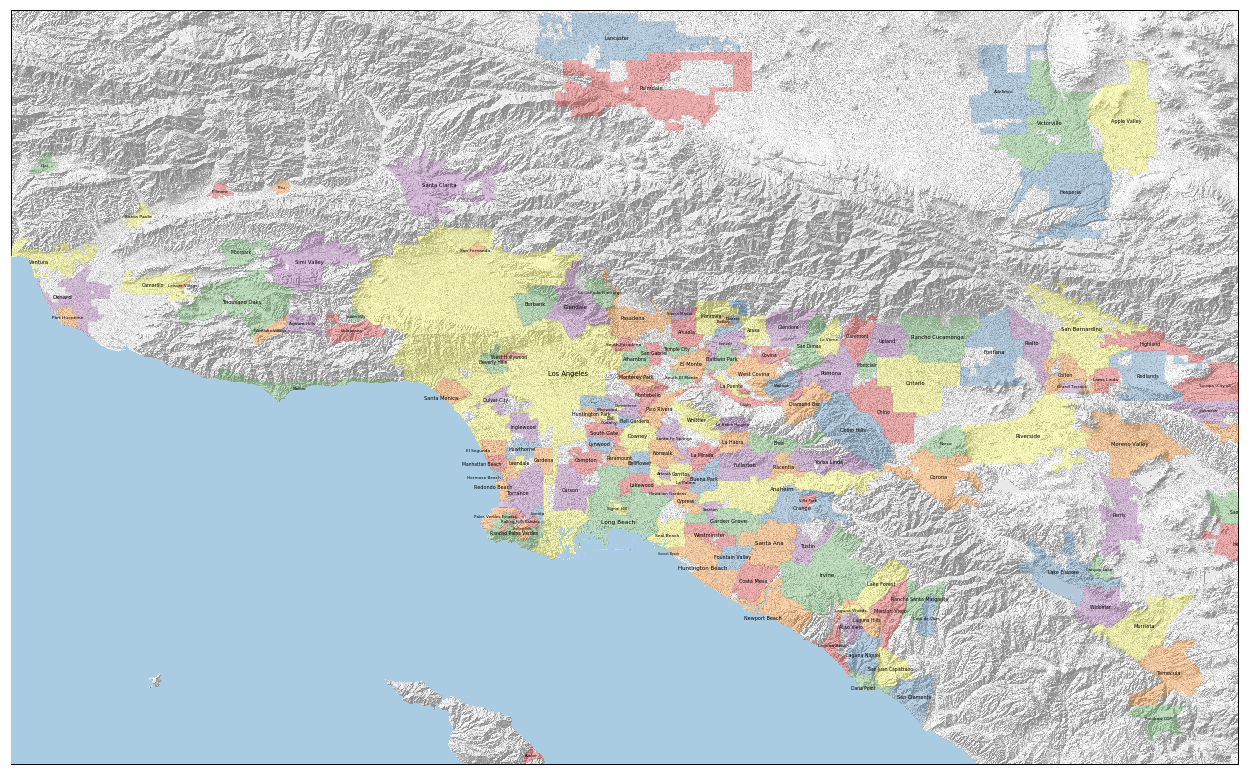

In [135]:
fig = plt.figure(figsize=(22, 22))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-119.31,-116.9998611, 33.32, 34.74])
# ax.set_extent([-118.8,-117.6, 33.5, 34.5])
extent=[-120.0001389, -116.9998611, 32.9998611, 35.0001389]
ax.imshow(intensity, cmap='gist_gray', alpha=0.5, origin='upper', extent=extent, zorder=0)

cities = set()
skip = ['Covina (City of)', b'La Ca\xf1ada Flintridge']
for record in reader.records():
    name = record.attributes['name']
    geometry = record.geometry
    if name == '' or name in cities or name in skip:
        continue
    cities.add(name)
    ax.add_geometries([geometry], ccrs.PlateCarree(), 
                      alpha=0.3, color=colormap[name], 
                      edgecolor='k', lw=0.1, zorder=5)
    if population.get(name):
        size = np.log10(population[name]) if population[name] > 0 else 1
    else:
        size = np.log10(10000)
    x = geometry.centroid.x
    y = geometry.centroid.y
    if tweaks.get(name):
        x += tweaks[name][0]
        y += tweaks[name][1]
    ax.text(x, y, name, fontsize=size, zorder=20, clip_on=True,
            ha='center', va='center', transform=ccrs.PlateCarree())

cm = LinearSegmentedColormap.from_list('water', [(169/255, 204/255, 227/255),(169/255, 204/255, 227/255)])
ax.imshow(water, cmap=cm, origin='upper', alpha=1.0, extent=extent, zorder=10)


plt.savefig('la_cities.pdf', dpi=600)
plt.show()